In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

import os

import math  

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

addp=2
startp=80
endp=120
dp=endp-startp
p_tot=addp*(dp-1)+1

In [2]:
def miscore(predtmp,oritmp):
    score=1
    n=1
    sh=predtmp.shape
    if sh!=oritmp.shape:
        print('len not match')
        return 1
    for i in range(len(sh)-1):
        n=n*sh[i]
    pred=predtmp.reshape(n,2)
    ori=oritmp.reshape(n,2)
    n=0
    for i in range(len(pred)):
        if ori[i,0]!=0 or ori[i,1]!=0:
            n=n+1
    #print(n)
    for i in range(len(pred)):
        if ori[i,0]!=0 or ori[i,1]!=0:
            score=score-1/n*abs((math.sqrt(pred[i,0]*pred[i,0]+pred[i,1]*pred[i,1])-math.sqrt(ori[i,0]*ori[i,0]+ori[i,1]*ori[i,1]))/(math.sqrt(pred[i,0]*pred[i,0]+pred[i,1]*pred[i,1])+math.sqrt(ori[i,0]*ori[i,0]+ori[i,1]*ori[i,1])))
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('MI:')
    print(score)
    return score

In [3]:
def siscore(predtmp,oritmp):
    score=0
    n=1
    sh=predtmp.shape
    if sh!=oritmp.shape:
        print('len not match')
        return 1
    for i in range(len(sh)-1):
        n=n*sh[i]
    pred=predtmp.reshape(n,2)
    ori=oritmp.reshape(n,2)
    n=0
    for i in range(len(pred)):
        if ori[i,0]!=0 and ori[i,1]!=0:
            n=n+1
    #print(n)
    for i in range(len(pred)):
        if ori[i,0]!=0 and ori[i,1]!=0:
            score=score+1/n*abs((ori[i,0]*pred[i,0]+ori[i,1]*pred[i,1])/math.sqrt(pred[i,0]*pred[i,0]+pred[i,1]*pred[i,1])/math.sqrt(ori[i,0]*ori[i,0]+ori[i,1]*ori[i,1]))
            #print(abs(pred[i]-ori[i])/abs(ori[i]))
    print('SI:')
    print(score)
    return score

In [4]:

file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
x=[]
y=[]
vx=[]
vy=[]
isvalid=[]
xtmp=[]
ytmp=[]
vxtmp=[]
vytmp=[]
isvalidtmp=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00001.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp.append(float(num[0]))
                    ytmp.append(float(num[1]))
                    vxtmp.append(float(num[2]))
                    vytmp.append(float(num[3]))
                    isvalidtmp.append(float(num[4]))

            x.append(np.array(xtmp).reshape(25,25))
            y.append(np.array(ytmp).reshape(25,25))
            vx.append(np.array(vxtmp).reshape(25,25))
            vy.append(np.array(vytmp).reshape(25,25))
            isvalid.append(np.array(isvalidtmp).reshape(25,25))
            xtmp=[]
            ytmp=[]
            vxtmp=[]
            vytmp=[]
            isvalidtmp=[]
#
x=np.array(x)
y=np.array(y)
vx=np.array(vx)
vy=np.array(vy)
isvalid=np.array(isvalid)

x=x.T
y=y.T
vx=vx.T
vy=vy.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=0.00002

t=t[startp:endp]
print(len(t))
t_train=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_train=t_train[1]-t_train[0]
print(len(t_train.shape))

40
1


In [5]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x[:,:,0].T,y[:,:,0].T]).T

n=25

u=np.zeros((n,n,121, 2))

u[:, :, :, 0] = vx
u[:, :, :, 1] = vy
u_train=np.zeros((n,n,len(t), 2))

u_train=u[:,:,startp:endp,:]

v_train=np.zeros((n,n,len(t_train),2))

for i in range(len(t)-1):
    for j in range(addp):
        v_train[:,:,addp*i+j]=(u_train[:,:,i]*(addp-j)+u_train[:,:,i+1]*j)/addp
v_train[:,:,-1]=u_train[:,:,-1]


In [6]:
v_train_dot = ps.FiniteDifference(axis=2)._differentiate(v_train, dt_train)

vtmp=np.zeros(v_train_dot.shape)
vtmp[:,:,0]=v_train[:,:,0]
for i in range(len(t_train)-1):
    vtmp[:,:,i+1]=vtmp[:,:,i]+v_train_dot[:,:,i]*dt_train
miscore(vtmp,v_train)

vtmp=v_train+v_train_dot*dt_train

vtmp[:,:,1:]=vtmp[:,:,:len(t_train)-1]
miscore(vtmp,v_train)
siscore(vtmp,v_train)


MI:
0.9355729317243612
MI:
0.9665519269814528
SI:
0.9888108312733358


0.9888108312733358

In [7]:
# Define PDE library that is quadratic in u, and
# fourth-order in spatial derivatives of u.    

library_functions = [
    lambda y: y,
    lambda x: x,

    lambda x, y: x * y * y,
    lambda x, y: x * x * y,
]
library_function_names = [
    lambda y: y,
    lambda x: x,

    lambda x, y: x + y + y,
    lambda x, y: x + x + y,
]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=1,
    spatial_grid=spatial_grid,
    include_bias=True,
    is_uniform=True,
    periodic=True
)


# Again, loop through all the optimizers
#print('STLSQ model: ')
print('v_train')
print(v_train.shape)

print('SINDy')
model = ps.SINDy(feature_names=['Vx','Vy'])

model.fit(v_train, x_dot=v_train_dot)
model.print()
#u_dot_stlsq = model.predict(v_train)



v_train
(25, 25, 79, 2)
SINDy
(Vx)' = 59.491 1 + 25.543 Vx + -32.535 Vy + 3.382 Vx^2 + -2.068 Vx Vy + 2.840 Vy^2
(Vy)' = -88.916 1 + 9.693 Vx + -6.849 Vy + -2.171 Vx^2 + -4.365 Vx Vy + -0.151 Vy^2


In [8]:
print("Model score: %f" % model.score(u_train, t=t))
print("Model score: %f" % model.score(u_train, t=dt))
print("Model score: %f" % model.score(v_train, t=t_train))
print("Model score: %f" % model.score(v_train, t=dt_train))

Model score: 0.011124
Model score: -0.004513
Model score: 0.005643
Model score: 0.005643


In [9]:
file_path = os.path.join('D:\\', 'hotaidata','sr_C6_01')
x_test=[]
y_test=[]
vx_test=[]
vy_test=[]
isvalid_test=[]
xtmp_test=[]
ytmp_test=[]
vxtmp_test=[]
vytmp_test=[]
isvalidtmp_test=[]
for root,dirs,files in os.walk(file_path):
    #print(root)
    
    for dir in dirs:
        #print(os.path.join(root,file))

            with open(os.path.join(root,dir,'B00002.dat'), 'r') as f:  
                lines = f.readlines()
                for line in lines[3:]: 
                    num=line.split()
                    xtmp_test.append(float(num[0]))
                    ytmp_test.append(float(num[1]))
                    vxtmp_test.append(float(num[2]))
                    vytmp_test.append(float(num[3]))
                    isvalidtmp_test.append(float(num[4]))

            x_test.append(np.array(xtmp_test).reshape(25,25))
            y_test.append(np.array(ytmp_test).reshape(25,25))
            vx_test.append(np.array(vxtmp_test).reshape(25,25))
            vy_test.append(np.array(vytmp_test).reshape(25,25))
            isvalid_test.append(np.array(isvalidtmp_test).reshape(25,25))
            xtmp_test=[]
            ytmp_test=[]
            vxtmp_test=[]
            vytmp_test=[]
            isvalidtmp_test=[]
#
x_test=np.array(x_test)
y_test=np.array(y_test)
vx_test=np.array(vx_test)
vy_test=np.array(vy_test)
isvalid_test=np.array(isvalid_test)

x_test=x_test.T
y_test=y_test.T
vx_test=vx_test.T
vy_test=vy_test.T
#print(x[0,:,:])
t=np.linspace(0,60/800,121)
dt=0.00002

t=t[startp:endp]
print(len(t))
t_test=np.linspace(t[0],t[-1],addp*(len(t)-1)+1)
dt_test=t_test[1]-t_test[0]
print(len(t_train.shape))
si_t=np.zeros(p_tot)
mi_t=np.zeros(p_tot)

40
1


In [10]:
#u is not pre adding, v add a median
spatial_grid = np.asarray([x_test[:,:,0].T,y_test[:,:,0].T]).T

n=25


u[:, :, :, 0] = vx_test
u[:, :, :, 1] = vy_test
u_test=np.zeros((n,n,len(t), 2))

u_test=u[:,:,startp:endp,:]

v_test=np.zeros((n,n,len(t_test),2))

for i in range(len(t)-1):
    for j in range(addp):
        v_test[:,:,addp*i+j]=(u_test[:,:,i]*(addp-j)+u_test[:,:,i+1]*j)/addp
v_test[:,:,-1]=u_test[:,:,-1]


In [11]:
x_dot_test_predicted = model.predict(u_test)
x_dot_test_predicted=x_dot_test_predicted.reshape(25,25,dp,2)
tlen=len(t)
dot_tmp=np.array(x_dot_test_predicted)
pltpredict=np.zeros((n,n,tlen,2))
print(dot_tmp[10,10])

[[ -49.15857549 -110.43163732]
 [ -45.06234873 -115.84886852]
 [ -29.84585596 -141.86141482]
 [ -39.05110887 -127.14522191]
 [ -45.99200868 -116.64082513]
 [  13.11686838 -207.79460664]
 [ -33.80069437 -136.99319932]
 [ -26.37345701 -140.13717473]
 [  -9.78537929 -176.62345997]
 [  17.78027127 -211.07660909]
 [ -23.06963605 -153.75972215]
 [ -17.53997111 -143.0268271 ]
 [  72.85211303 -137.21043034]
 [  32.54229462 -163.78129342]
 [  -7.67113081 -115.50118068]
 [  -9.19398387 -121.95316319]
 [ -37.21607109 -111.30403081]
 [  55.73363545  -89.25374494]
 [  50.55946839 -103.79118496]
 [  -9.72230518 -109.81824275]
 [  49.74391541  -91.22742519]
 [  35.99267243 -112.50295752]
 [ 130.42030302  -83.94946526]
 [ 132.13981897  -75.15679771]
 [ 113.1805387   -74.36395223]
 [ 223.35401681  -44.13153164]
 [ 286.33835352  -25.35936138]
 [ 239.14707871  -77.62997425]
 [ 383.55955851   -2.6930016 ]
 [ 448.79194286  -34.15422395]
 [ 480.8787804    27.94310218]
 [ 510.31944198   37.58562266]
 [ 504.6

In [12]:
pltpredict[:,:,0]=v_train[:,:,0]
for i in range(tlen-1):
    pltpredict[:,:,i+1]=pltpredict[:,:,i]+dot_tmp[:,:,i]*dt
miscore(pltpredict,u_test)
siscore(pltpredict,u_test)
#print(pltpredict[10,10])

MI:
0.767225835957719
SI:
0.8109572295339347


0.8109572295339347

0


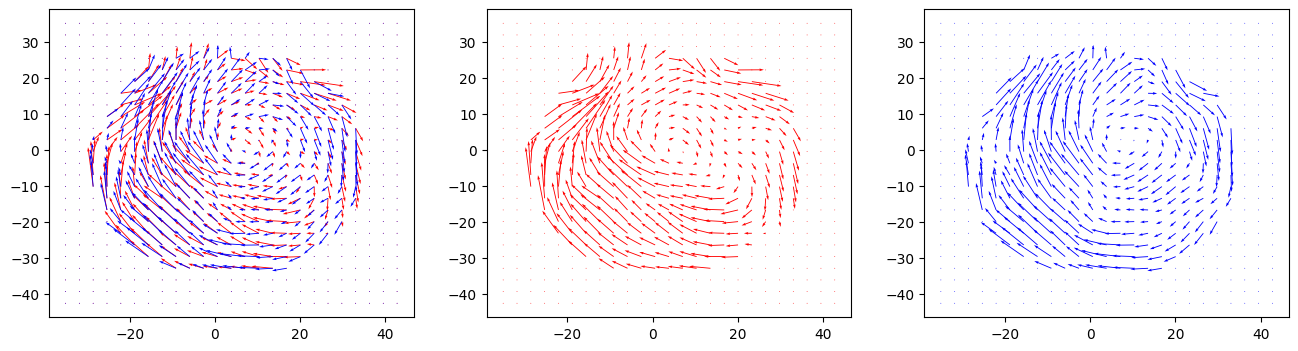

MI:
0.8161539697357465
SI:
0.8653140133675518
1
MI:
0.8189663908634378
SI:
0.9027644272250575
2


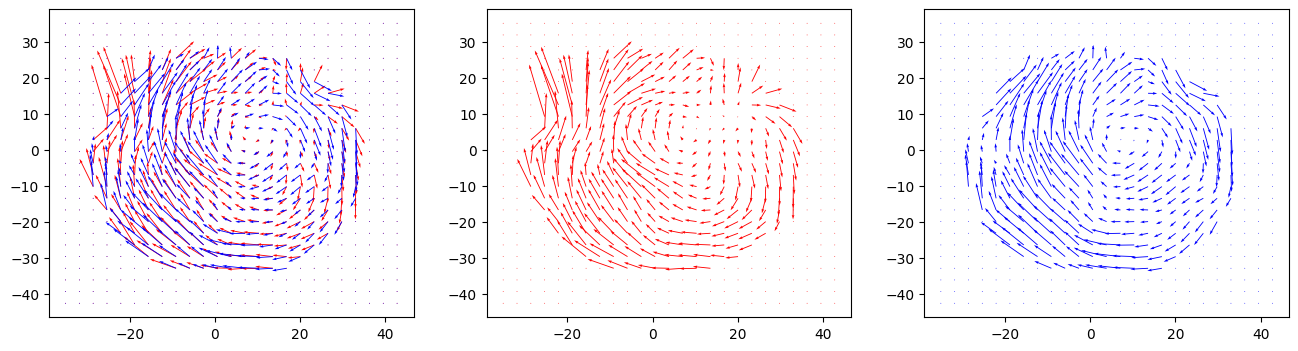

MI:
0.8060817700605463
SI:
0.8796956705024137
3
MI:
0.7946738498242749
SI:
0.9124348434538251
4


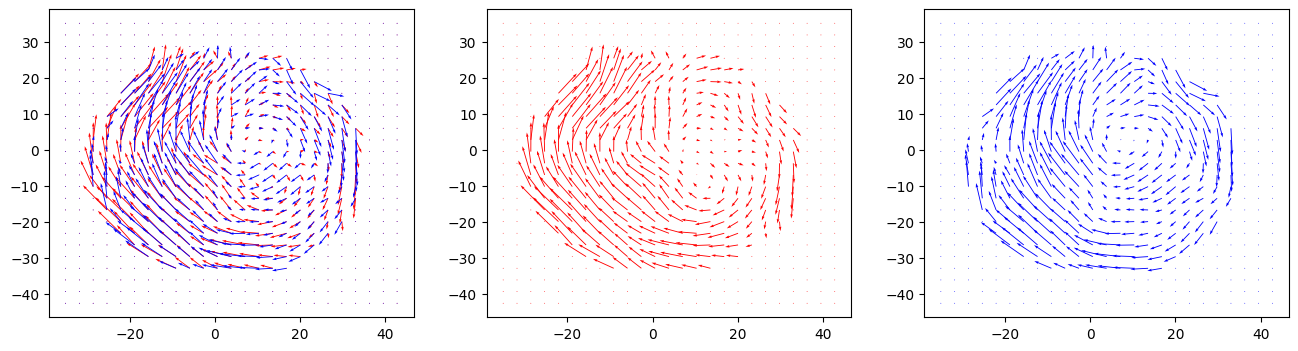

MI:
0.7989884123011098
SI:
0.8950299369382458
5
MI:
0.7926889536298057
SI:
0.9062088944430728
6


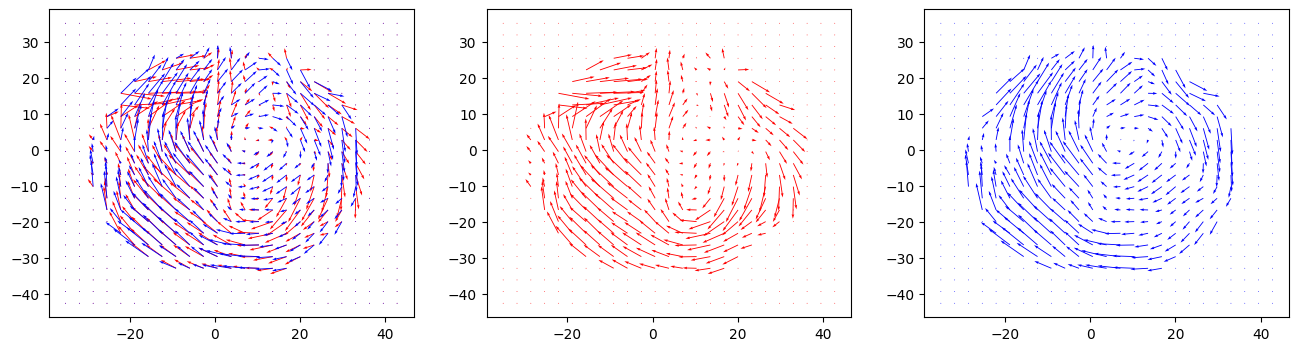

MI:
0.7854892275761882
SI:
0.8790328462078323
7
MI:
0.8160726417819578
SI:
0.914237266845309
8


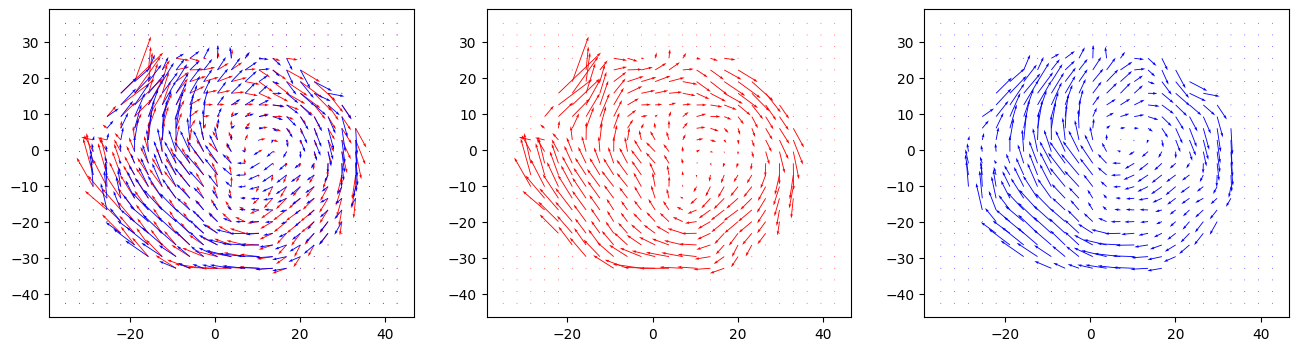

MI:
0.8171385249849249
SI:
0.9003786223623244
9
MI:
0.8399736936442246
SI:
0.9375648960349036
10


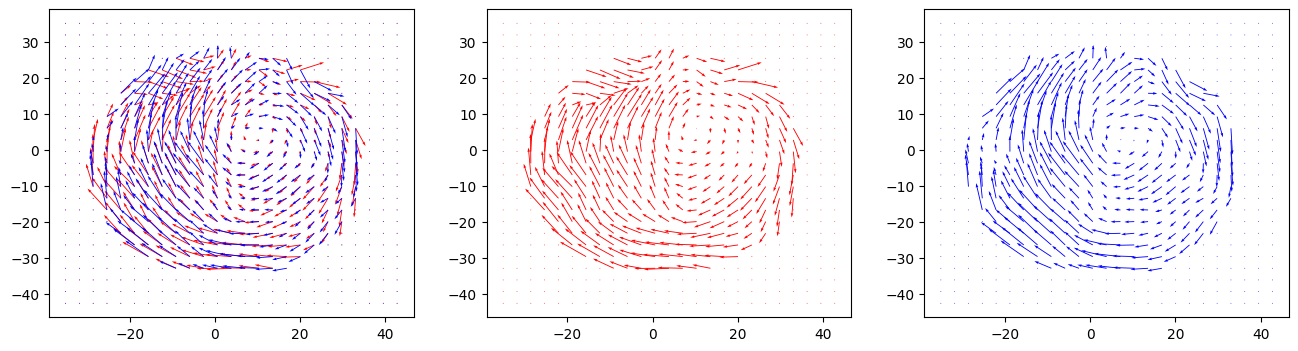

MI:
0.8259811480145132
SI:
0.9148271469654123
11
MI:
0.803177753060545
SI:
0.9148192093237212
12


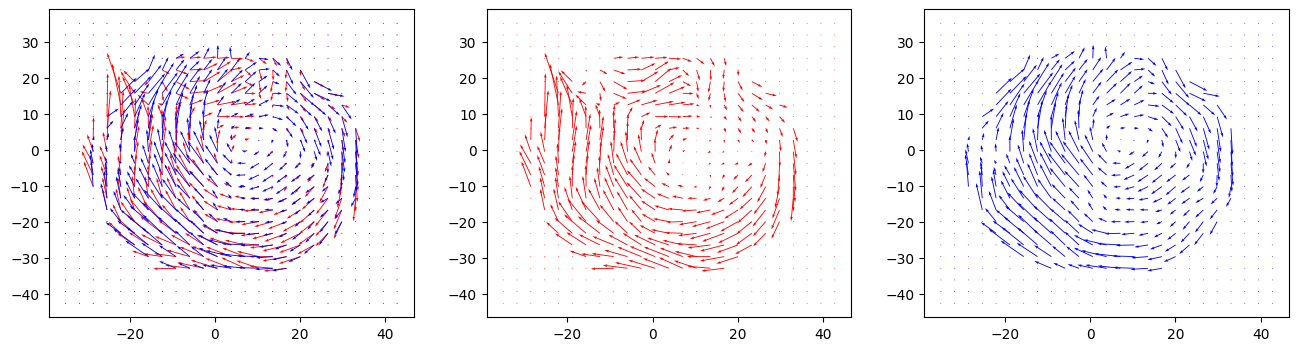

MI:
0.7569425497674662
SI:
0.8720251468782965
13
MI:
0.7620753953713744
SI:
0.9135936859711582
14


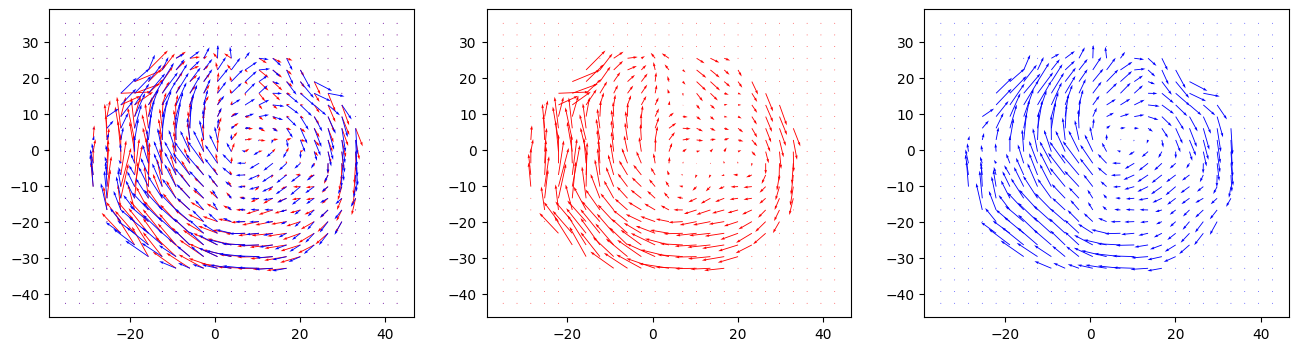

MI:
0.7710892393872403
SI:
0.9006220699950539
15
MI:
0.7846874983271152
SI:
0.9303448342923017
16


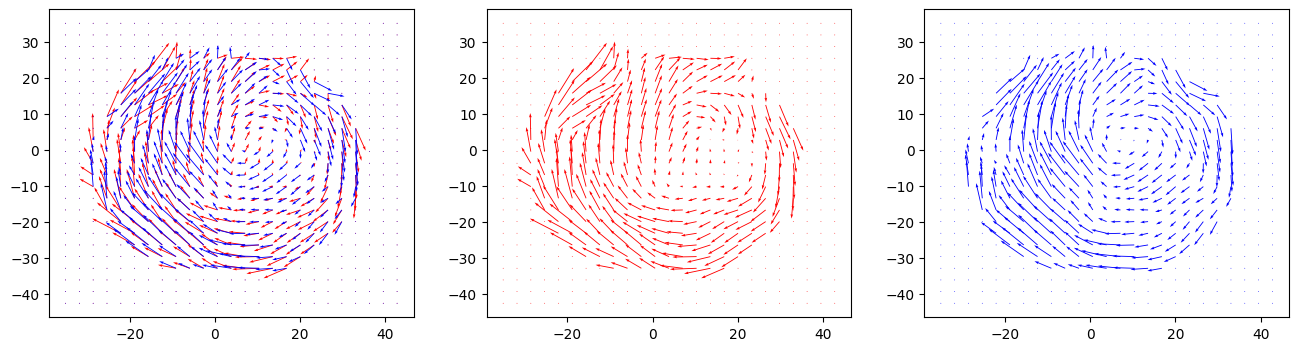

MI:
0.7959982085240017
SI:
0.8929806156149862
17
MI:
0.8101337988688625
SI:
0.9229342721636811
18


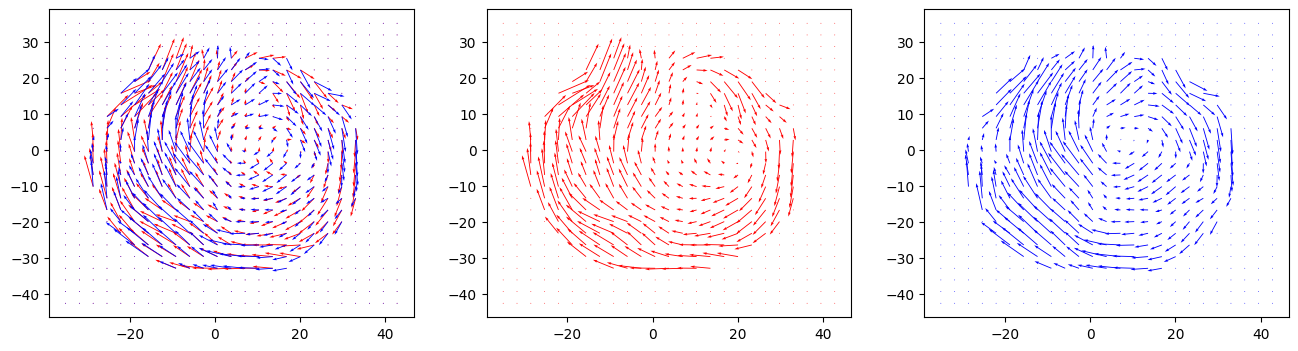

MI:
0.8139665792189685
SI:
0.9182300756557438
19
MI:
0.8045543354479776
SI:
0.9259405476122977
20


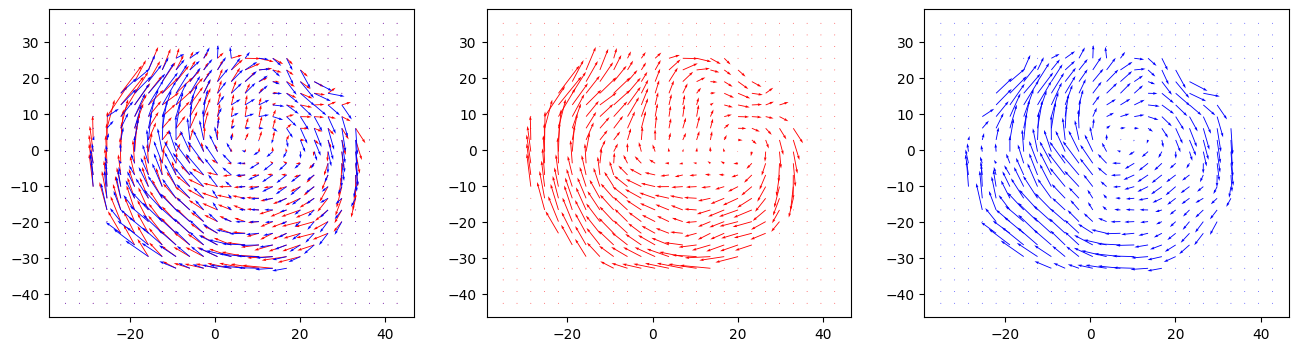

MI:
0.7948230280273488
SI:
0.899693835209446
21
MI:
0.7875175347599357
SI:
0.9005147807624425
22


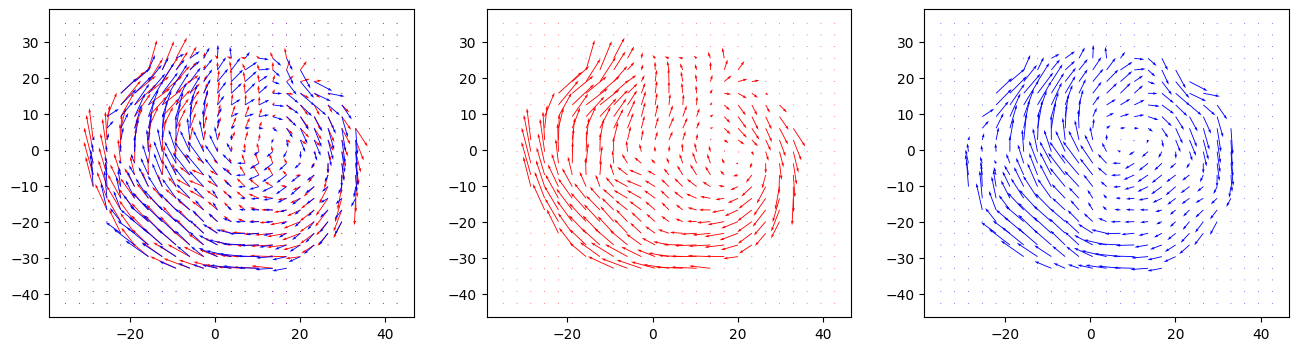

MI:
0.7930016022653049
SI:
0.887965835129067
23
MI:
0.7859924292864137
SI:
0.9036812715955852
24


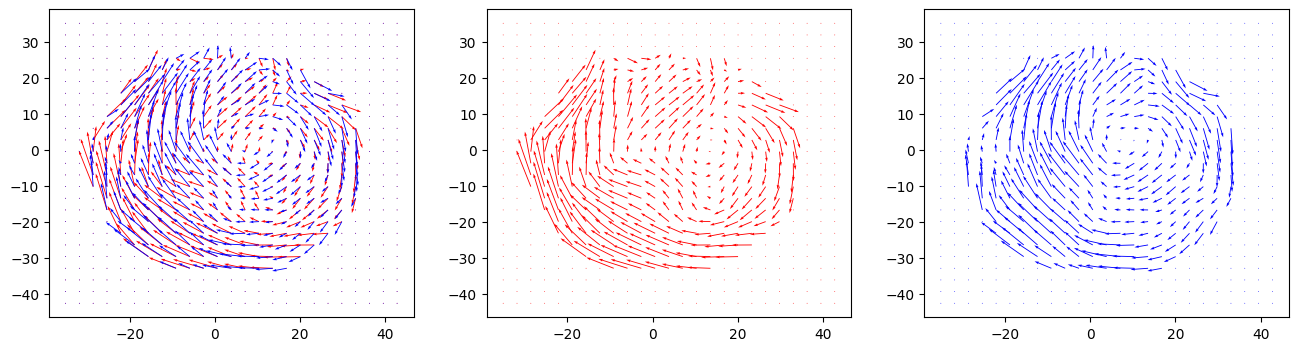

MI:
0.792478685888627
SI:
0.892977916200088
25
MI:
0.778764433398195
SI:
0.9191037234164064
26


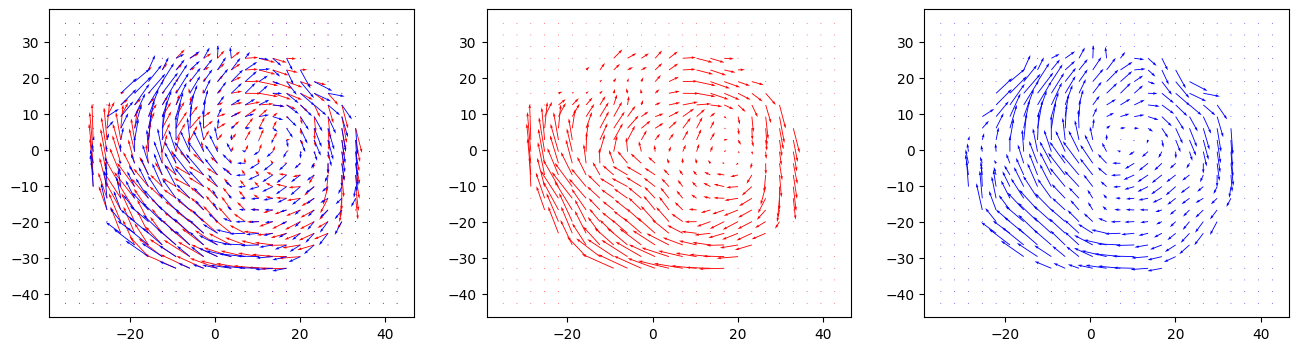

MI:
0.7486203921374635
SI:
0.9005211821961575
27
MI:
0.7767074972801473
SI:
0.9123776960165123
28


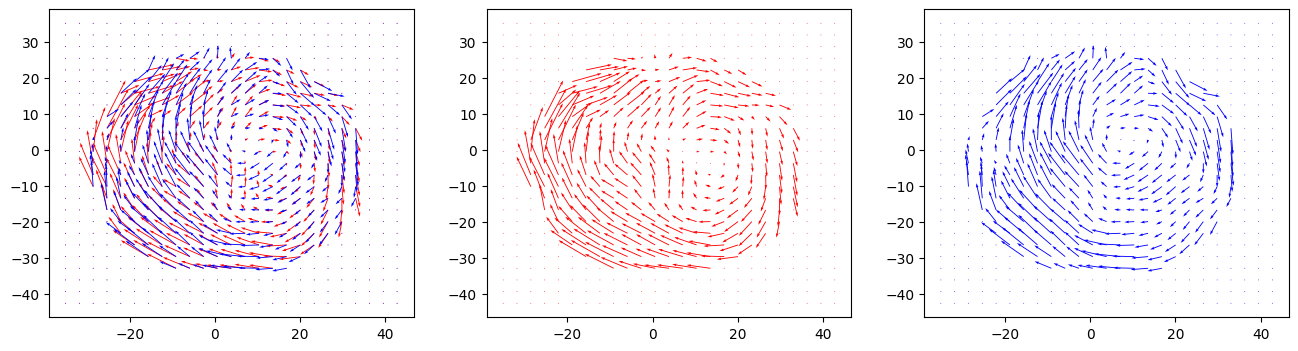

MI:
0.781659782549671
SI:
0.9020836918883093
29
MI:
0.7870911449414163
SI:
0.9005594632101883
30


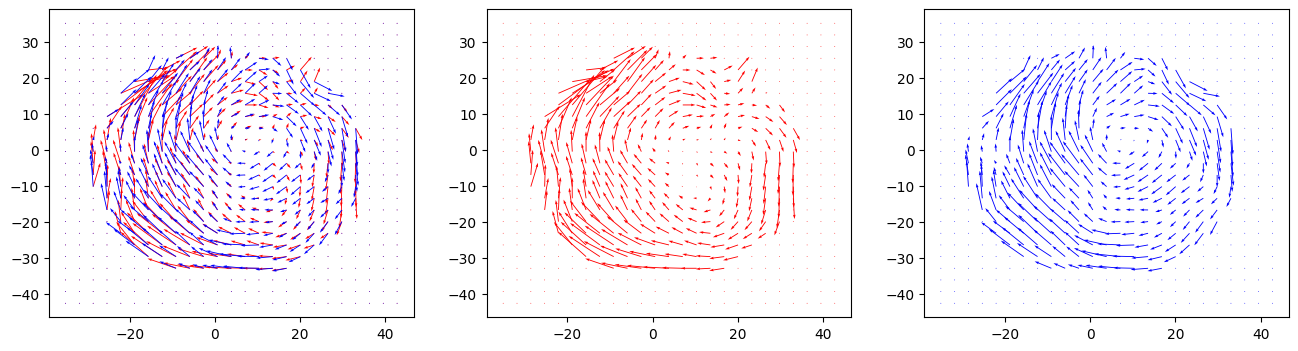

MI:
0.786909679393968
SI:
0.8640066713354461
31
MI:
0.7827408118491959
SI:
0.8859401382516224
32


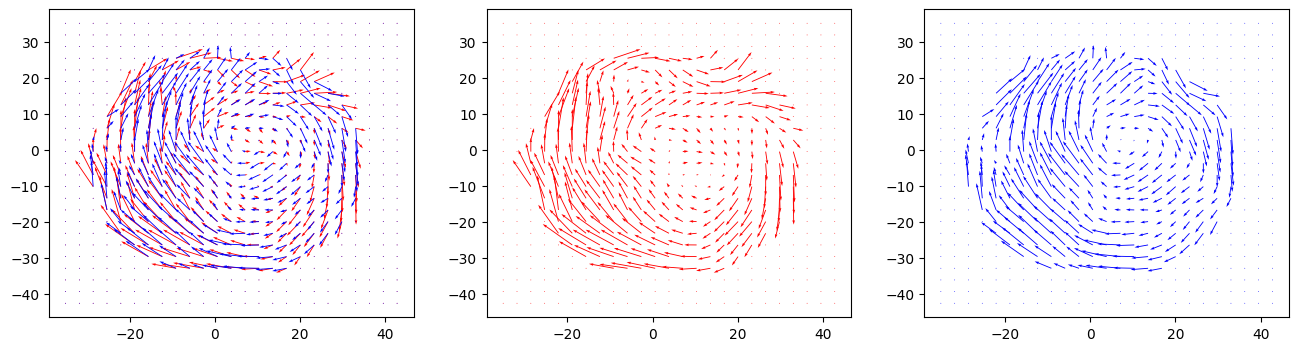

MI:
0.7715408159136058
SI:
0.8696236895948688
33
MI:
0.7642050207159271
SI:
0.9116079184614787
34


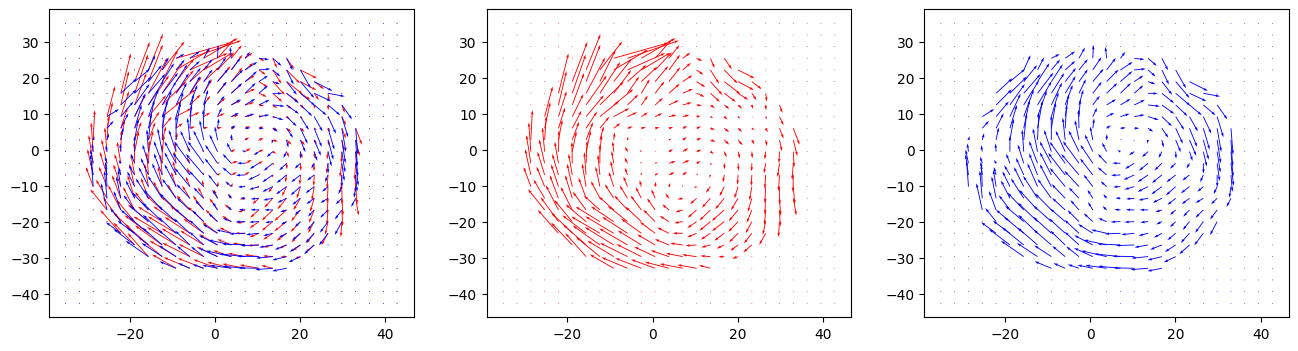

MI:
0.7485290431603202
SI:
0.8938986305925566
35
MI:
0.7564468855894985
SI:
0.9063698424601156
36


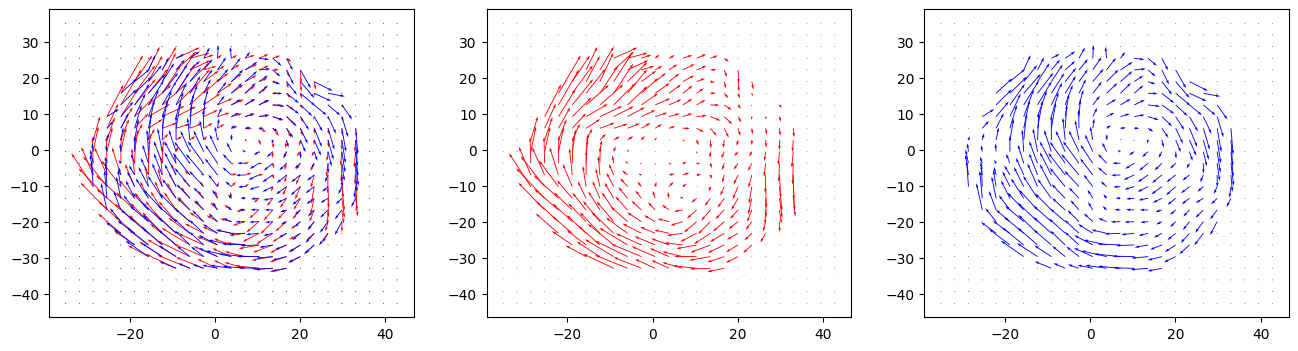

MI:
0.7402941620424489
SI:
0.8894109514591299
37
MI:
0.7530680056499317
SI:
0.9001572937465057
38


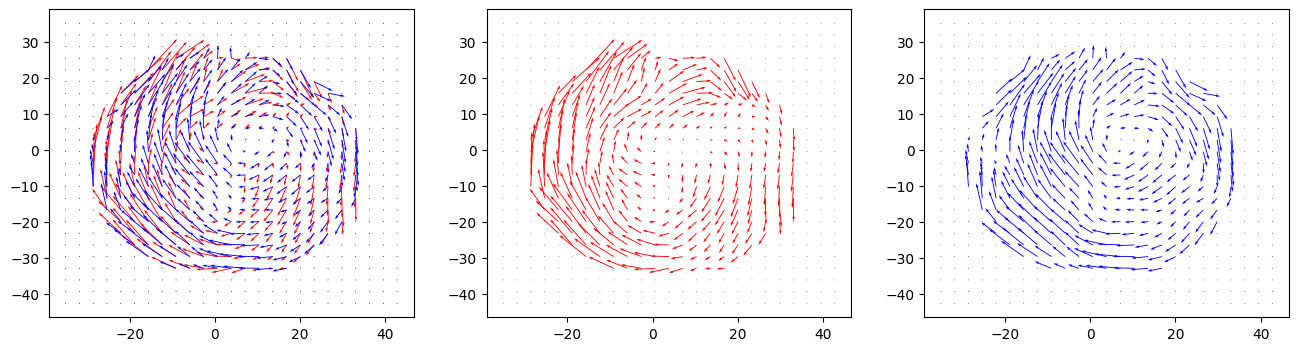

MI:
0.7491926478224258
SI:
0.8598545530232122
39
MI:
0.7727792108836558
SI:
0.8774365527275896


In [13]:
for i in range(dp):
    print(i)
    j=i
    if i%(addp)==0:
        plt.figure(figsize=(16, 4))
        plt.subplot(1, 3, 1)
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
        plt.subplot(1, 3, 2)
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],v_test[:,:,j,0],v_test[:,:,j,1],color='r')
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],pltpredict[:,:,i,0],pltpredict[:,:,i,1],color='b')
        plt.subplot(1, 3, 3)
        #plt.quiver(spatial_grid[:,:,1],spatial_grid[:,:,0],u_dot_train[:,:,i+1,0],u_dot_train[:,:,i+1,1],color='r')
        plt.quiver(spatial_grid[:,:,0],spatial_grid[:,:,1],pltpredict[:,:,j,0],pltpredict[:,:,j,1],color='b')
        plt.show()
    mi_t[i]=miscore(pltpredict[:,:,j,],v_test[:,:,j,:])
    si_t[i]=siscore(pltpredict[:,:,j,],v_test[:,:,j,:])

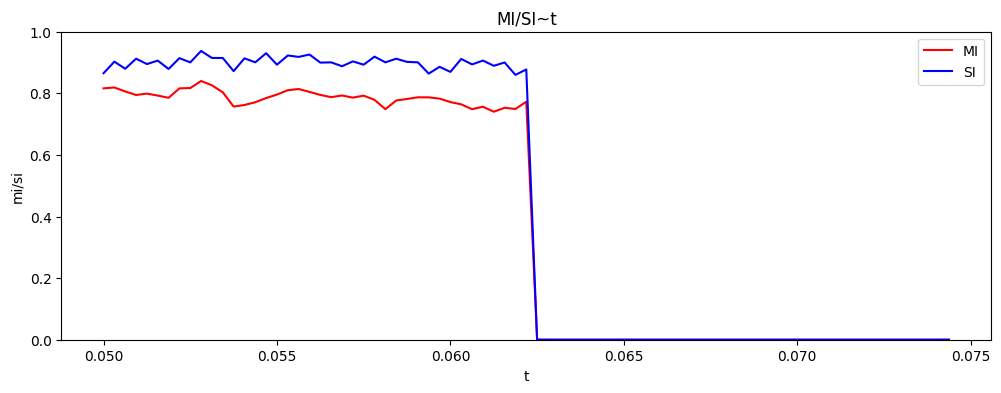

In [14]:
plt.figure(figsize=(12, 4))
plt.title('MI/SI~t')
plt.ylim(0,1)
plt.xlabel('t')
plt.ylabel('mi/si')
plt.plot(t_train,mi_t,'r',label='MI')
plt.plot(t_train,si_t,'b',label='SI')
plt.legend()
plt.plot
plt.show()